# Problem Description

A client collects the last **update time** for each table on an hourly basis and uses it
for detection of **data freshness issues** (see here). The attached CSV file contains table
update times inferred from this data, with the below schema.
Each table’s updates can be thought of as a unique time-series.
We aim to provide to the client at each inference run of our model a list of tables which
are currently experiencing issues.


The client wants to be alerted when the update time is not regular - **Freshness Issue**. A freshness issue can be reprsented by a **clear cut** in the table's update times.

A clear cut is when the period of time between two updates times is irregular - not normal - according to rest of them. Too big jump or too small, example: every upadte appears approximately every 3 hours but suddenly we an update 30 minutes after the last one, here we face a **clear cut**. 

At each instant we want to provide to the client a list of tables that are suffering of freshness issue - have a clear cut.

We call the variable **delta** the difference between two consecutives updates times.

# Packages

In [42]:
import pandas as pd
import numpy as np
import random

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import plotly.graph_objects as go


from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from tslearn.utils import to_time_series_dataset

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

from scipy import stats
from sklearn.decomposition import PCA


import warnings
warnings.filterwarnings('ignore')

# Utilities

In [3]:
# fig = go.Figure()
# buttons = []
# n = 10
# for c, table in enumerate(df.FULL_TABLE_ID.sample(n=n).values.tolist()):
#     dft = df[df.FULL_TABLE_ID==table]
#     x = dft.UPDATE_TIME
#     y = dft.delta
#     name = table
#     fig.add_trace(go.Scatter(x=x, y=y, name=name))
    
#     button = dict(label = table,
#                   method = 'update',
#                   args = [{'visible': [True if i==c else False for i in range(n)]},
#                           {'title': table,
#                            'showlegend':True}])
#     buttons.append(button)
    
    
# fig.update_layout(
#     updatemenus=[go.layout.Updatemenu(
#         active=0,
#         buttons=buttons
#         )
#     ])

# fig.show()



def make_table_data(df, table_name):
    dft = df[df.FULL_TABLE_ID==table_name]
    dft.sort_values(by='UPDATE_TIME', inplace=True)
    dft['delta'] = [0] + pd.Series(np.diff(dft.UPDATE_TIME)).dt.total_seconds().div(60).values.tolist()
    dft.reset_index(drop=True, inplace=True)
    return dft


def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


def trend_seasonal_residual(t_serie, period_length):
    #trend
    trend = moving_average(t_serie, period_length)
    
    #seasonal
    delta = t_serie[period_length-1:] - trend
    r = True
    l = len(delta)
    while r:
        if l % period_length !=0:
            l = l + 1
        else:
            r = False
    a = np.append(delta, [0 for i in range(l-len(delta))])
    a = a.reshape(-1, period_length)
    season = np.mean(a, axis=0)
    S = season.copy()
    for i in range(a.shape[0]-1):
        S = np.append(S, season)
    
    seasonal = S[:len(delta)]

    #residual
    residual = delta - seasonal
    
    return trend, seasonal, residual


def autocorrelation(t_serie):
    R = []
    for lag in range(len(t_serie)):
        R.append(acf(t_serie, nlags=lag)[-1])
    return np.array(R)
    
    
def prepare_data(t_serie, test_percent, AR_deg):
    #define X
    X = t_serie.reshape(-1, 1)
    if AR_deg != 0:
        for i in range(AR_deg-1):
            t_serie_lag = np.append(t_serie[1:], t_serie[:1])
            X = np.concatenate((X, t_serie_lag.reshape(-1,1)), axis=1)
            t_serie = t_serie_lag
        #define y
        y = np.append(X[1:, AR_deg-1], X[:1, AR_deg-1])
    else:
        y = np.append(X[1:], X[:1])
    #split data
    split_idx = int(test_percent*len(X))
    X_train = X[:split_idx, :]
    X_test = X[split_idx:, :]
    y_train = y[:split_idx]
    y_test = y[split_idx:]

    
    return X_train, X_test, y_train, y_test


def time_series_train_model(t_serie, test_percent, AR_deg):
    
    X_train, X_test, y_train, y_test = prepare_data(t_serie, test_percent, AR_deg)
    
    model = LinearRegression().fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    
    y_test_pred = model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_test_pred)
    
    return model, mse_train, mse_test, y_test_pred, y_test


def find_periodicity(t_serie):
    R = autocorrelation(t_serie)
    pdg = np.fft.rfft(R)
    freqs = np.fft.rfftfreq(len(R))
    return int(1/freqs[abs(pdg).argmax()])

# TS Delta Data

The data is composed by:
1. the name of the table
2. the update time - UPDATE_TIME
3. the Monte Carlo collection time - FIRST_MEASURED

We notice here that FIRST_MEASURED must be after UPDATE_TIME.

In [34]:
df = pd.read_csv('MC_freshness_data_new.csv')
df['UPDATE_TIME'] = pd.to_datetime(df['UPDATE_TIME'])
df['FIRST_MEASURED'] = pd.to_datetime(df['FIRST_MEASURED'])
df['correct_measure'] = list(map(int, df['UPDATE_TIME']<=df['FIRST_MEASURED']))
df.sort_values(by=['FULL_TABLE_ID', 'UPDATE_TIME'], inplace=True)
df['delta'] = [0] + pd.Series(np.diff(df.UPDATE_TIME)).dt.total_seconds().div(60).values.tolist()
# df = df.groupby('FULL_TABLE_ID').apply(lambda group: group.iloc[1:, 1:]).reset_index()
# df.drop(['level_1'], axis=1, inplace=True)

In [35]:
df

,FULL_TABLE_ID,UPDATE_TIME,FIRST_MEASURED,correct_measure,delta
174012,ANALYTICS:DBT_DDABUSH_INTERNAL_BI_STAGE.SALESF...,2022-03-15 14:00:00,2022-03-15 14:07:00,1,0.0
85297,ANALYTICS:DBT_DDABUSH_INTERNAL_BI_STAGE.SALESF...,2022-03-15 14:10:00,2022-03-15 15:08:22,1,10.0
128121,ANALYTICS:DBT_DDABUSH_INTERNAL_BI_STAGE.SALESF...,2022-03-22 09:48:00,2022-03-22 10:42:01,1,9818.0
165422,ANALYTICS:DBT_DDABUSH_INTERNAL_BI_STAGE.SALESF...,2022-03-22 13:40:00,2022-03-22 13:45:07,1,232.0
117422,ANALYTICS:DBT_DDABUSH_INTERNAL_BI_STAGE.SALESF...,2022-03-29 13:54:00,2022-03-29 14:22:15,1,10094.0
...,...,...,...,...,...
97717,raw:spark.warehouse_lineage_vertices,2022-04-05 10:18:00,2022-04-05 10:40:17,1,56.0
2296,raw:spark.warehouse_lineage_vertices,2022-04-05 11:18:00,2022-04-05 11:40:28,1,60.0
107361,raw:spark.warehouse_lineage_vertices,2022-04-05 12:18:00,2022-04-05 12:41:33,1,60.0
156456,raw:spark.warehouse_lineage_vertices,2022-04-05 13:42:00,2022-04-05 13:42:37,1,84.0


In [38]:
df.shape[0], df.isnull().sum().sum()

(181471, 0)

In [39]:
df['FULL_TABLE_ID'].unique().shape

(1101,)

In [40]:
df.correct_measure.value_counts()

1    180335
0      1136
Name: correct_measure, dtype: int64

In [41]:
df.delta.describe()

count    181471.000000
mean          0.166737
std        5114.937333
min      -86346.000000
25%          60.000000
50%          62.000000
75%         178.000000
max       76050.000000
Name: delta, dtype: float64

1. No missing values
2. 181471 samples
3. 1101 unique tables
4. 1136 incorrect measurements

# Tables Data

In [76]:
dict_tables = df.FULL_TABLE_ID.value_counts().to_dict()
df_tables = pd.DataFrame(index=dict_tables.keys(), data=dict_tables.values(), columns=['NbSample'])

df_tables['FirstDate'] = df.groupby(['FULL_TABLE_ID']).first().FIRST_MEASURED
df_tables['LastDate'] = df.groupby(['FULL_TABLE_ID']).last().FIRST_MEASURED
df_tables['NbDays'] = (df_tables.LastDate-df_tables.FirstDate).astype('timedelta64[D]')

df_tables['SamplePerDay'] = (df_tables.NbSample/(df_tables.NbDays)).replace([np.inf, -np.inf], 0)

df_tables['Mode'] = df.groupby(['FULL_TABLE_ID']).delta.agg(lambda x: stats.mode(x)[0][0])
df_tables ['Median'] = df.groupby(['FULL_TABLE_ID']).delta.agg(lambda x: np.median(x))
df_tables ['Mean'] = df.groupby(['FULL_TABLE_ID']).delta.agg(lambda x: np.mean(x))

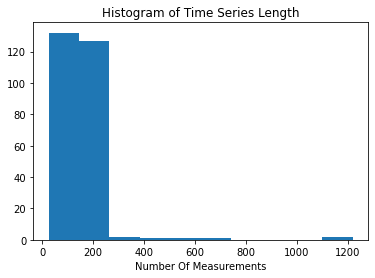

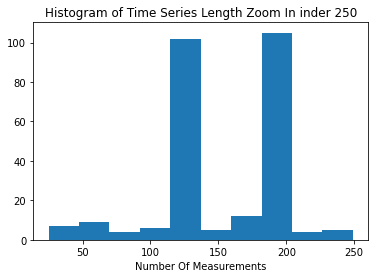

In [95]:
plt.hist(x=df_tables.NbSample, bins=10, density=False)
plt.title('Histogram of Time Series Length')
plt.xlabel('Number Of Measurements')
plt.show()
plt.hist(x=df_tables[df_tables.NbSample<250].NbSample, bins=10, density=False)
plt.title('Histogram of Time Series Length Zoom In inder 250')
plt.xlabel('Number Of Measurements')
plt.show()

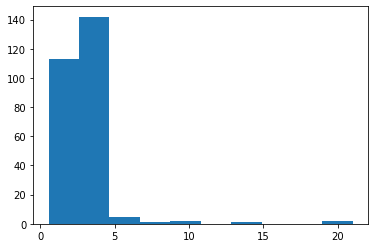

In [96]:
plt.hist(x=df_tables.SamplePerDay, bins=10, density=False)
plt.show()

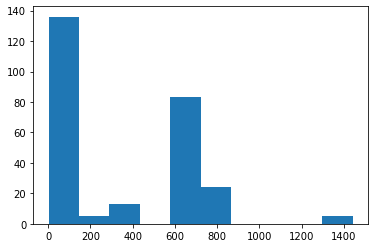

In [97]:
plt.hist(x=df_tables.Mode, bins=10, density=False)
plt.show()

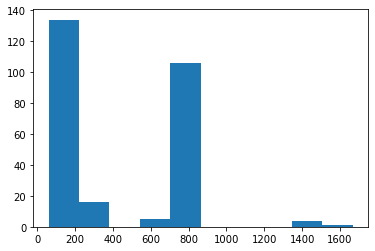

In [98]:
plt.hist(x=df_tables.Median, bins=10, density=False)
plt.show()

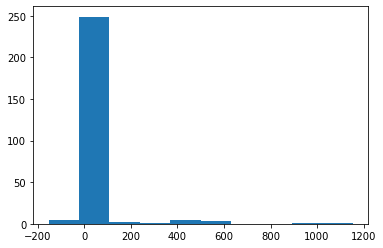

In [99]:
plt.hist(x=df_tables.Mean, bins=10, density=False)
plt.show()

# Data Filtering

In [78]:
list_tables_to_remove = df[df.correct_measure==0].FULL_TABLE_ID.unique().tolist()

df = df[~df.FULL_TABLE_ID.isin(list_tables_to_remove)]

df_tables = df_tables.loc[df[df.correct_measure==1].FULL_TABLE_ID.unique().tolist(),:]

In [93]:
list_tables_to_remove = df_tables[df_tables.NbSample<20].index.tolist()

df = df[~df.FULL_TABLE_ID.isin(list_tables_to_remove)]

df_tables = df_tables[df_tables.NbSample>=20]

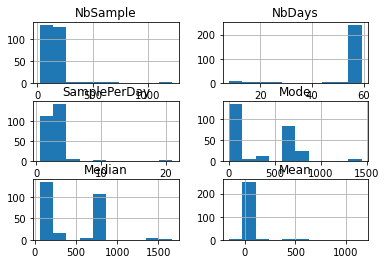

In [94]:
df_tables.hist()
plt.show()

# Freshness Time Series EDA

The freshness time series is caculated by substracting the update time by the next one. So we analyze the time beetween tow update time.

In the perfect world, these time series should almost be flat, with small fluctuations, but freshness issue brings jumps in the data.

Some strong assumptions can be made on the data:
1. Times series are non stationaries in variance - sudden bloom event
2. Times series do not have specific period or season - flat with fluctuation looks like noise
3. Distribution of a time series values follows a normal distribution


We can notice different types of time series which indicates that clustering is possible to identify groups in the entire data.

In [100]:
list_table_name = df_tables.sample(n=15).index.tolist()

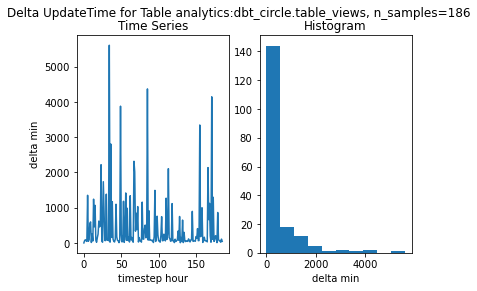

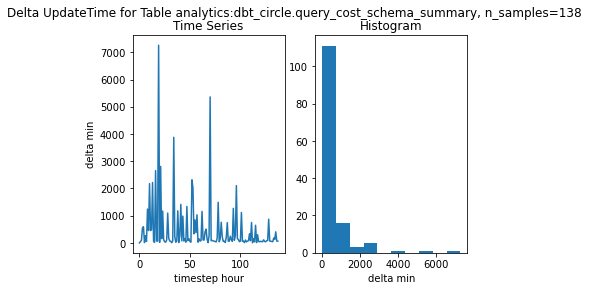

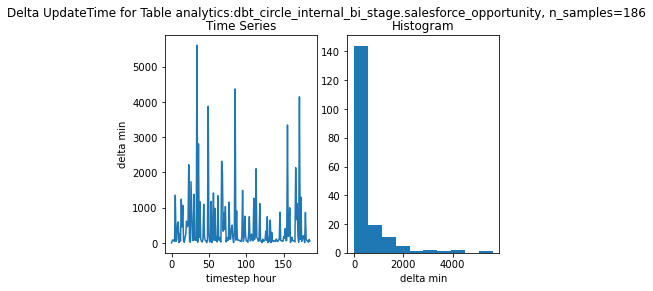

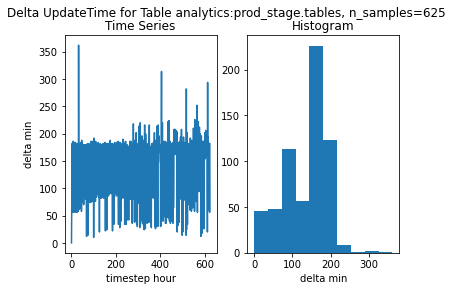

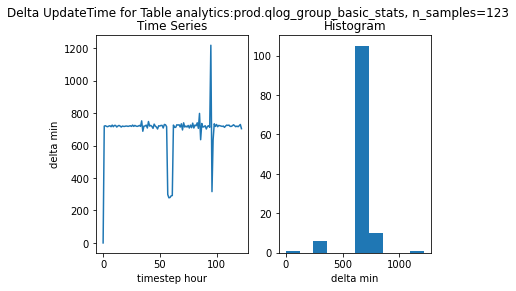

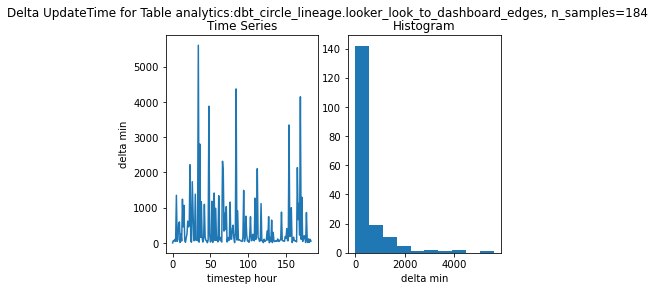

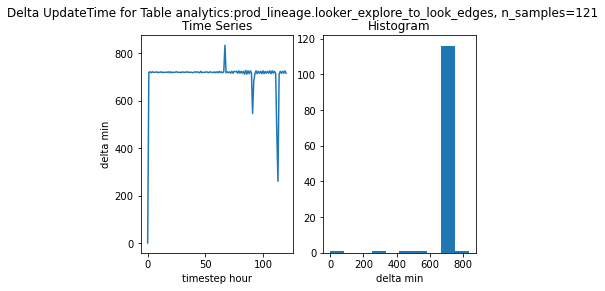

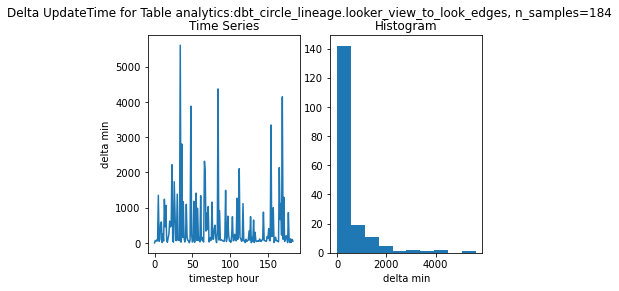

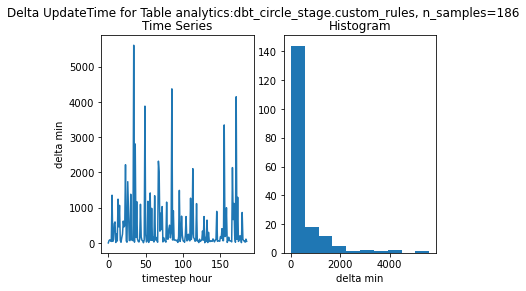

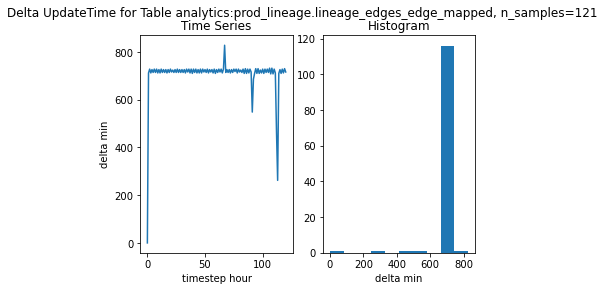

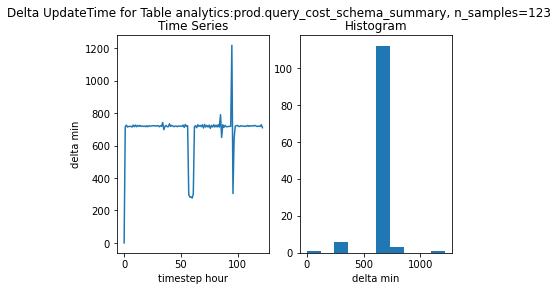

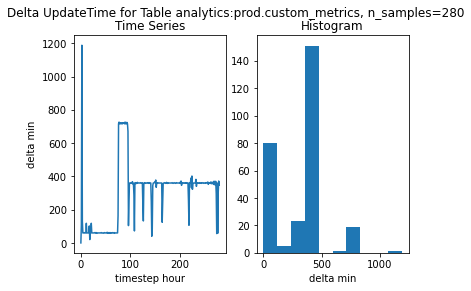

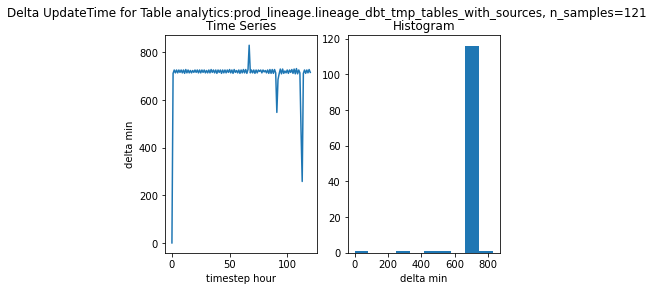

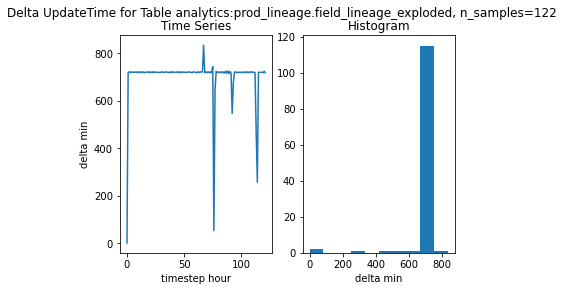

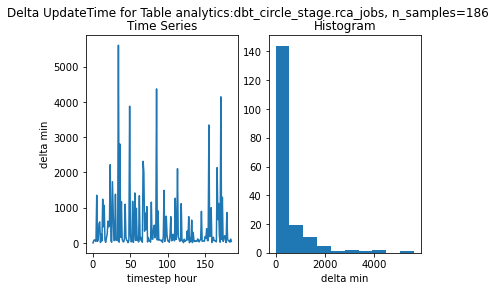

In [101]:
for table_name in list_table_name:
    
    dft = make_table_data(df, table_name)
    
    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.suptitle('Delta UpdateTime for Table {}, n_samples={}'.format(table_name, dft.shape[0]))
    ax[0].plot(dft.delta.values)
    ax[0].set_title('Time Series')
    ax[0].set_xlabel('timestep hour')
    ax[0].set_ylabel('delta min')
    ax[1].hist(dft.delta.values)
    ax[1].set_title('Histogram')
    ax[1].set_xlabel('delta min')
    plt.show()
    

We ploted the time series and its distribution for 8 random tables

# Model V0

To detect if a clear cut appears in the time series we create a model based on the statistic of the time serie distribution. 

By getting the mean, the standard deviation of the distribution and a parameter, we create a upper and lower limits then we test if a time serie value is inside.

The model parameter allows us to play on the width, thus the precision and the recall of the model. With a high value we increase the precision and with a lower value we increase the recall.

In [16]:
dft = make_table_data(df, df_tables[df_tables.NbSample>300].sample(n=1).index[0])

In [17]:
dft.shape

(625, 5)

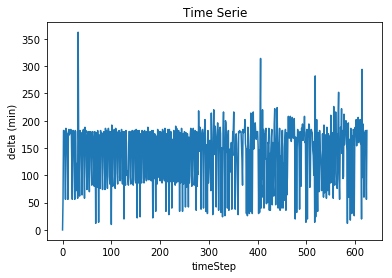

In [18]:
dft.delta.plot()
plt.title('Time Serie')
plt.xlabel('timeStep')
plt.ylabel('delta (min)')
plt.show()

## Model Class

In [297]:
class modelv0():
    def __init__(self, a):
        self.a = a
        self.fit_parameters = []
    
    def fit(self, x):
        m = x.mean()
        s = x.std()
        self.fit_parameters.append(m)
        self.fit_parameters.append(s)
        
    def predict(self, y):
        a = self.a
        m = self.fit_parameters[0]
        s = self.fit_parameters[1]
        
        r = ((y-m)/s)**2 - a**2
        b = r>=0
        return r, b

## Model Training

In [316]:
x = dft.delta.values
model = modelv0(1)
model.fit(x)
r,b = model.predict(x)
dft['clear_cut_val'] = r
dft['clear_cut'] = b

## Visualization

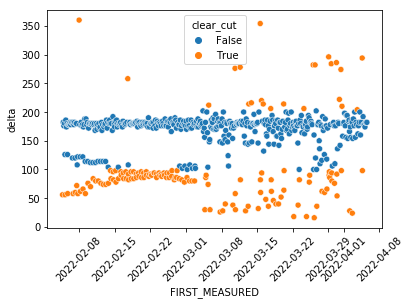

In [317]:
sns.scatterplot(data=dft.loc[1:,:], x="FIRST_MEASURED", y="delta", hue="clear_cut")
plt.xticks(rotation = 45)
plt.show()

We observe in blue a clear middle line with some fluctuation reprsents the regular values of delta update time.

In orange we have the clear cuts.

## True Positive / False Positive Discussion

We can observe how important the clear cuts are.

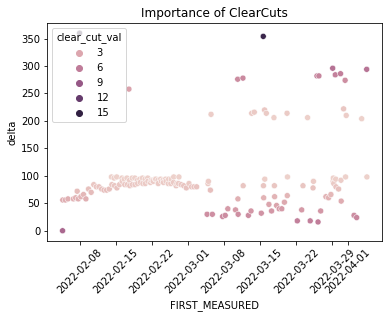

In [318]:
sns.scatterplot(data=dft[dft.clear_cut==1], x="FIRST_MEASURED", y="delta", hue="clear_cut_val")
plt.xticks(rotation = 45)
plt.title('Importance of ClearCuts')
plt.show()

The variable **clear_cut_val** is a value given by the model and represents how strong is clear cut is - it ranks the model 's detections.

This can help to discuss about FPs and TPs.

We can discuss about TPs and FPs:


**True Positifs**

The TPs are the correct clear cuts detected by the model. They are points enough far from the average value of the data. The maximal and minimal values of the data represents well a clear cut as example. We can look on the previous graph *Importance of ClearCuts* that points with a **clear cut val** upper than 12 represents true positifs clear cuts.

**False Positifs**

The FPs are points detected as clear cut but are not. 
Some of them is due to the strictness of the model (parameter a) like the points with a **clear cut val** inferior to 6. However, we can observe point that follow a repetition, so belong to a trend, those points are not clear cuts.

## Precision / Recall Assessment

We can look for the best model's parameter by observing the average ratio between the number of samples and the number of clear cuts detected for each table in function of model's parameter.

In [303]:
M = []
for a in [0.25,0.5,1,1.5,2,2.5,3]:
    res = []
    for table_name in df_tables.index:
        dftt = make_table_data(df, table_name)
        x = dftt.delta.values
        model = modelv0(a)
        model.fit(x)
        r,b = model.predict(x)
        res.append(sum(b))
    df_tables['NbClearCut'] = res
    df_tables['ratio'] = df_tables.NbClearCut/df_tables.NbSample
    M.append(df_tables.ratio.mean())

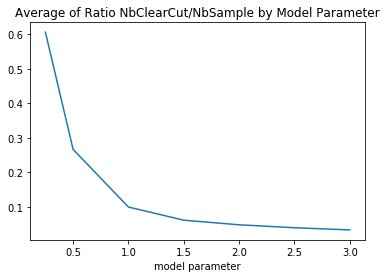

In [305]:
plt.plot([0.25,0.5,1,1.5,2,2.5,3], M)
plt.title('Average of Ratio NbClearCut/NbSample by Model Parameter')
plt.xlabel('model parameter')
plt.show()

More the parameter is high more the average ratio NbClearCut/NbSample reduces which indicates a raise in precision.

# Solutions For Improvements

The model v0 works well if we considerate that a clear cut is detected by training on the majority of the time series or all data points. It means that the period of time between two updates time do not change over time (sationarity). However we can considerate the possibility that the period changes.

In real life it would be like:
We have a new product to insert but the new features must be added in a table T, and this requires to change the period between two update times.

**First Option - Use the past**

We adapt the model to take a list a previous values of the time series - it allows to learn localy what is a clear cut and adapt over time.

>* EFFORT: small - 2/3 hours (implement + test + validation)
>* IMPACT: Expect big Impact - Rise in Precision and Recall because the model adapt according to previous values. The accuracy will increase.

**Second Option - Better Hypothesises**

The model v0 use a normal distribution for all times series, however we saw that it exists several types of time series in the data. We can modify the model parameters according to the best distribution fit. But, we will need to find the best distribution first.

>* EFFORT: medium - 5-10 days (implement + test + validation)
>* IMPACT: The precision will increase but not sure for the recall - the model will probably works better for certain types of distributions

**Third Option - DBSCAN**

I think here that DBSCAN is a good fit for this problem, why:
DBSCAN is an unsupervised algorithm for clustering data. It s density based method, for each data points it looks for the closest ones and can group them or seperate them. This model has also the specificity to find outliers in the data (for our project - the clear cuts). In addition DBSCAN is sensible to the order of points and always generats the same clusters.

>* EFFORT: medium - 5 days (implement + test + validation)
>* IMPACT: Hard to tell 


In terms of ROI:
1. First Option
    1. Easy to implement and will provide high precision
2. Second Option 
    1. Not sure to be easier or with better results but can also generats data for other purposes - we collect the type of distributions of each time series.
3. Third Option
  

# Model V1 - Use the past

## Model Class

In [25]:
class modelv1():
    def __init__(self, a, p):
        self.a = a
        self.p = p
        self.fit_local_parameters = []
    
    def fit(self, x):
        j = 0
        for i in range(len(x)):
            if i<self.p:
                xp = x[:i]
            else:
                xp = x[i-self.p:i]
            mp = xp.mean()
            sp = xp.std()
            self.fit_local_parameters.append([mp,sp])
        
    def predict(self, x):
        
        P = np.array(self.fit_local_parameters).reshape(-1,2)
        mps = P[:,0]
        sps = P[:,1]
        
        r = ((x-mps)/sps)**2 - self.a**2
        b = r>=0
        return r, b

## Model Training

In [29]:
x = dft.delta.values
model = modelv1(3,20)
model.fit(x)
r,b = model.predict(x)
dft['clear_cut_val'] = r
dft['clear_cut'] = b

## Visualization

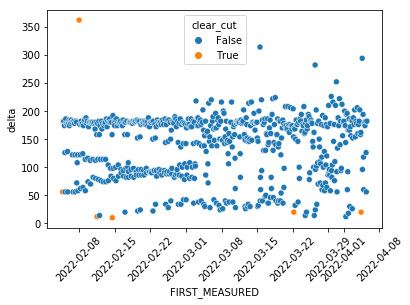

In [31]:
sns.scatterplot(data=dft.loc[1:,:], x="FIRST_MEASURED", y="delta", hue="clear_cut")
plt.xticks(rotation = 45)
plt.show()

## True Positive / False Positive Discussion

FPs and TPs discussion:

Now we have a model with higher precision and more adaptibility. With the model v0 a lot of points was considerated as clear cut but it was due to a change in the statistics (non stationary). Now, model v1 catch only the most relevant clear cuts in the time series.

Thes results depends also on how we defined what is a clear cut.

The type of time series we are dealing with can change the result but the model v1 is easy to tune. To be sure of the general imporvement of the model v1 we need to analyze it for each type of time serie distribution.

